In [1]:
    from functools import partial

    import matplotlib.pyplot as plt
    import numpy as np

    import cirq
    from mitiq.zne import execute_with_zne
    from mitiq.zne.inference import LinearFactory

In [2]:
    # Qubit register
    qreg = cirq.LineQubit.range(2)

    # Two Pauli operators
    string1 = cirq.PauliString(cirq.ops.X.on(qreg[0]), cirq.ops.Z.on(qreg[1]))
    string2 = cirq.PauliString(cirq.ops.Y.on(qreg[1]))

    # Hamiltonian
    ham = 1.5 * string1 - 0.7 * string2

In [4]:
    def executor(
        circuit: cirq.Circuit,
        hamiltonian: cirq.PauliSum,
        noise_value: float
    ) -> float:
        """Runs the circuit and returns the expectation value of the Hamiltonian.

        Args:
            circuit: Defines the ansatz wavefunction.
            hamiltonian: Hamiltonian to compute the expectation value of w.r.t. the ansatz wavefunction.
            noise_value: Probability of depolarizing noise.
        """
        # Add noise
        noisy_circuit = circuit.with_noise(cirq.depolarize(noise_value))

        # Get the final density matrix
        dmat = cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix

        # Return the expectation value
        return hamiltonian.expectation_from_density_matrix(
            dmat,
            qubit_map={ham.qubits[i]: i for i in range(len(ham.qubits))}
        ).real

In [5]:
    def ansatz(gamma: float) -> cirq.Circuit:
        """Returns the ansatz circuit."""
        return cirq.Circuit(
            cirq.ops.ry(gamma).on(qreg[0]),
            cirq.ops.CNOT.on(*qreg),
            cirq.ops.rx(gamma / 2).on_each(qreg),
            cirq.ops.CNOT.on(*qreg),
        )

In [6]:
    pvals = np.linspace(0, 0.01, 20)
    expvals = [executor(ansatz(gamma=np.pi), ham, p) for p in pvals]

In [7]:
    fac = LinearFactory(scale_factors=list(range(1, 6)))
    mitigated_expvals = []

    for p in pvals:
        this_executor = partial(executor, hamiltonian=ham, noise_value=p)
        mitigated_expvals.append(
            execute_with_zne(ansatz(gamma=np.pi), this_executor, factory=fac)
        )

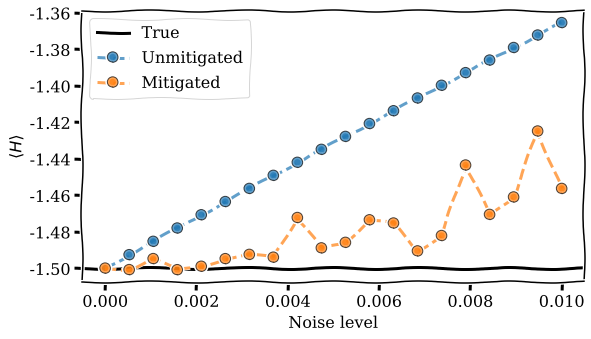

In [11]:
with plt.xkcd():
    plt.rcParams.update({"font.family": "serif", "font.size": 16})
    plt.figure(figsize=(9, 5))

    plt.axhline(y=expvals[0], lw=3., label="True", color="black")
    plt.plot(pvals, expvals, "--o", lw=3, markersize=10, markeredgecolor="black", alpha=0.7, label="Unmitigated")
    plt.plot(pvals, mitigated_expvals, "--o", lw=3, markersize=10, markeredgecolor="black", alpha=0.7, label="Mitigated")

    plt.xlabel("Noise level")
    plt.ylabel(r"$\langle H \rangle$")
    plt.legend()
    plt.savefig("vqe-cirq-pauli-sum-mitigation-plot.png", dpi=300, bbox_inches="tight")
    plt.show()